In [5]:
%reload_ext autoreload
%autoreload 2

from lib.data_loading import load_measurements, CombinedDataLoader

####

from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax import linen as nn

import matplotlib.pyplot as plt


data_dir = "data"
model_dir = Path("./models")
model_dir.mkdir(parents=True, exist_ok=True)

print(f"Data resides in        : {data_dir}")
print(f"Model will be saved to : {model_dir}")

Data resides in        : data
Model will be saved to : models


In [13]:
class ConditionalRBM(nn.Module):
    num_qubits: int
    num_hidden: int
    k: int = 100
    T: float = 1.0

    def setup(self):
        self.num_visible = self.num_qubits * 3

        self.W = self.param("W", nn.initializers.normal(0.01), (self.num_visible, self.num_hidden))
        self.b = self.param("b", nn.initializers.zeros, (self.num_visible,))
        self.c = self.param("c", nn.initializers.zeros, (self.num_hidden,))

        self.free_mask = jnp.tile(jnp.array([True, False, False]), self.num_qubits)

    def _free_energy(self, v):
        return -(v @ self.b) - jnp.sum(nn.softplus(v @ self.W + self.c), -1)

    @staticmethod
    def _gibbs_step(state, W, b, c, T):
        v, key = state
        key, h_key, v_key = jax.random.split(key, 3)
        h = jax.random.bernoulli(h_key, jax.nn.sigmoid((v @ W + c)/T)).astype(jnp.float32)
        v = jax.random.bernoulli(v_key, jax.nn.sigmoid((h @ W.T + b)/T)).astype(jnp.float32)
        return v, key

    # to be honsest, temperature is the only parameter that truly changes externally
    def _gibbs_step(self, state, fixed_units, T):
        # could be done more efficiently by just sampling the free units
        v, key = state
        key, h_key, v_key = jax.random.split(key, 3)
        h = jax.random.bernoulli(h_key, jax.nn.sigmoid((v @ self.W + self.c) / T))
        v  = jax.random.bernoulli(v_key, jax.nn.sigmoid((h @ self.W.T + self.b) / T))

        # overwrite the fixed units
        v  = jnp.where(self.free_mask, v, fixed_units)
        return v, key

    def __call__(self, batch: jnp.ndarray, key: jax.random.PRNGKey):
        batch_size = batch.shape[0]

        # flatten channel dimension
        v0 = batch.reshape(batch_size, -1).astype(jnp.float32)
        fixed_units = jnp.where(self.free_mask, 0., v0)

        body = lambda _, s: self._gibbs_step(s, fixed_units, self.T)
        vk, _ = jax.lax.fori_loop(0, self.k, body, (v0, key))

        loss = jnp.mean(self._free_energy(v0)) - jnp.mean(self._free_energy(vk))
        return loss, {}

    @nn.nowrap
    def generate(self,
                 dir_bits: jnp.ndarray,     # (B, n_qubits, 2)
                 T_schedule: jnp.ndarray,    # (L,)
                 key: jax.random.PRNGKey) -> jnp.ndarray:
        # WIP
        batch_size = dir_bits.shape[0]

        # first add empty channel, then flatten out
        fixed_triples = jnp.concatenate([jnp.zeros((batch_size, self.num_qubits, 1), dtype=dir_bits.dtype), dir_bits], axis=-1)
        fixed_units = fixed_triples.reshape(batch_size, -1).astype(jnp.float32)

        # could be done better with some kind of concatenation instead of replacing with .where
        key, key_init = jax.random.split(key)
        v0 = jax.random.bernoulli(key_init, 0.5, shape=(batch_size, self.num_visible)).astype(jnp.float32)
        v0 = jnp.where(self.free_mask, v0, fixed_units)

        # scan over T_schedule
        def scan_step(state, T):
            return self._gibbs_step(state, fixed_units, T), None

        (v_final, _), _ = jax.lax.scan(scan_step, (v0, key), T_schedule)
        return v_final.reshape(batch_size, self.n_qubits, 3)

In [14]:
@jax.jit
def train_step_cond(
        state: TrainState,
        batch: jnp.ndarray,            # (batch_size, num_qubits, 3)
        key: jax.random.PRNGKey) -> Tuple[TrainState, jnp.ndarray]:
    def loss_fn(params):
        loss, _ = state.apply_fn({'params': params}, batch, key)
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss


def train_cond_rbm(
        state: TrainState,
        loader: CombinedDataLoader,
        num_epochs: int,
        key: PRNGKey) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[int, Any] = {}
    for epoch in range(num_epochs):
        tot_loss, batches = 0.0, 0

        for batch in loader:
            key, key_batch = jax.random.split(key)
            state, loss = train_step_cond(state, batch, key_batch)
            tot_loss += float(loss)
            batches  += 1

        avg_loss = tot_loss / batches
        lr = float(lr_schedule(state.opt_state[0].count))

        metrics[epoch] = dict(loss=avg_loss, lr=lr)
        
        print(f"Epoch {epoch+1}/{num_epochs} │ "
            f"Loss: {avg_loss:+.4f} │ "
            f"Learning Rate: {lr:.5f}")

    return state, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2

    curve_fn = lambda step: low + (high - low) / (1 + jnp.exp(falloff * (jnp.minimum(step, steps) - center_step)))
    return curve_fn

In [15]:
file_path = Path("data/w_aug_combined.txt")
data = load_measurements(file_path)

Parsing measurements: 100%|██████████| 20000/20000 [00:00<00:00, 26863.89it/s]


In [16]:
batch_size   = 64
num_qubits   = 8
hidden_units = 24
k_steps      = 400
num_epochs   = 200
init_lr      = 1e-2
final_lr     = init_lr * 0.1


key_seed = PRNGKey(42)
key, key_params, key_dummy = jax.random.split(key_seed, 3)

model = ConditionalRBM(num_qubits=num_qubits, num_hidden=hidden_units, k=k_steps)

dummy_batch = jnp.zeros((batch_size, num_qubits, 3), dtype=jnp.float32)
variables = model.init({'params': key_params}, dummy_batch, key_dummy)

loader = CombinedDataLoader(data, batch_size=batch_size)

schedule_steps = num_epochs * len(loader)
lr_schedule = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)
optimizer = optax.adam(lr_schedule)

state = TrainState.create(apply_fn=model.apply, params=variables['params'], tx=optimizer)

state, metrics = train_cond_rbm(state, loader, num_epochs=num_epochs, key=key)

Epoch 1/200 │ Loss: +0.0214 │ Learning Rate: 0.01000
Epoch 2/200 │ Loss: +0.0098 │ Learning Rate: 0.01000
Epoch 3/200 │ Loss: +0.0200 │ Learning Rate: 0.01000
Epoch 4/200 │ Loss: +0.0169 │ Learning Rate: 0.01000
Epoch 5/200 │ Loss: +0.0182 │ Learning Rate: 0.01000
Epoch 6/200 │ Loss: +0.0174 │ Learning Rate: 0.01000
Epoch 7/200 │ Loss: +0.0197 │ Learning Rate: 0.01000
Epoch 8/200 │ Loss: +0.0236 │ Learning Rate: 0.01000
Epoch 9/200 │ Loss: +0.0196 │ Learning Rate: 0.01000
Epoch 10/200 │ Loss: +0.0189 │ Learning Rate: 0.01000
Epoch 11/200 │ Loss: +0.0167 │ Learning Rate: 0.01000
Epoch 12/200 │ Loss: +0.0194 │ Learning Rate: 0.01000
Epoch 13/200 │ Loss: +0.0238 │ Learning Rate: 0.01000
Epoch 14/200 │ Loss: +0.0166 │ Learning Rate: 0.01000
Epoch 15/200 │ Loss: +0.0202 │ Learning Rate: 0.01000
Epoch 16/200 │ Loss: +0.0266 │ Learning Rate: 0.01000
Epoch 17/200 │ Loss: +0.0221 │ Learning Rate: 0.01000
Epoch 18/200 │ Loss: +0.0200 │ Learning Rate: 0.01000
Epoch 19/200 │ Loss: +0.0249 │ Learni

KeyboardInterrupt: 

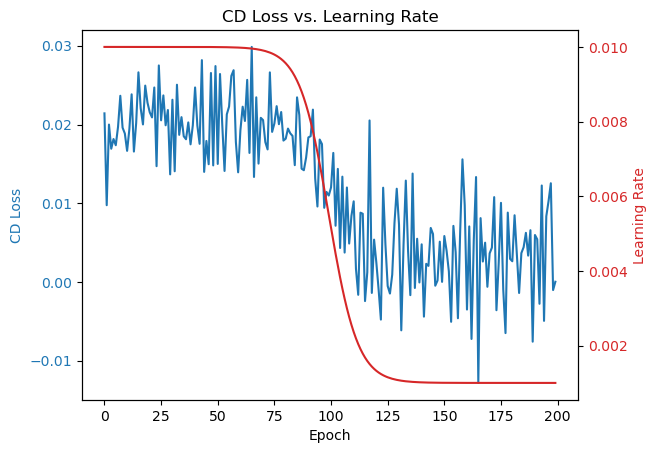

In [11]:
epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")

ax1.plot(epochs, loss_vals, label="CD Loss", color="tab:blue")
ax1.set_ylabel("CD Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax2.set_ylabel("Learning Rate", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("CD Loss vs. Learning Rate")
plt.show()

In [12]:
T_high = 2.0
T_low = 0.01
sampling_steps = 10_000
sigmoid_schedule_fn = get_sigmoid_curve(high=T_high*2, low=T_low, steps=sampling_steps, falloff=0.0013, center_step=0)
sigmoid_schedule = jnp.array([sigmoid_schedule_fn(i) for i in range(sampling_steps)], dtype=jnp.float32)

num_samples = 10_000
dir_bits = jnp.ones((num_samples, model.num_qubits, 2), dtype=jnp.int32)

key_sample = PRNGKey(1234)
samples = model.apply({'params': state.params}, dir_bits, sigmoid_schedule, key_sample, method=ConditionalRBM.generate)

# the output samples still have all three channels, we need only want to know the frequencies from the outcome channel
sampled_freq = samples[:, :, 0].mean(axis=0)
sampled_freq

AttributeError: "ConditionalRBM" object has no attribute "n_qubits".

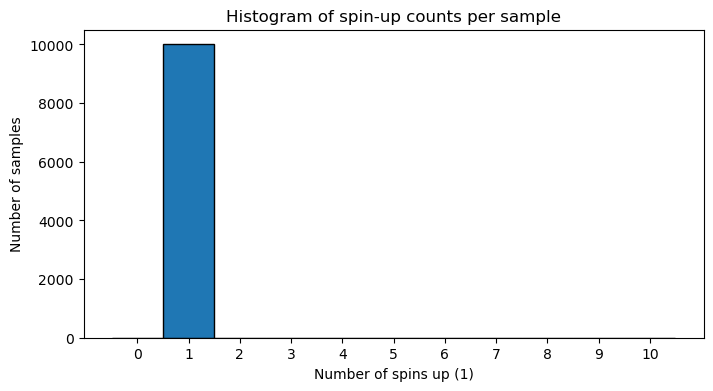

In [9]:
spin_counts = samples_amp.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(12), align='left', edgecolor='black')
plt.xticks(range(11))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()